# Pairwise sequence alignment 

One of the most fundamental problems in bioinformatics is determining how similar a pair of biological sequences are. There are many applications for this, including inferring the biological function of a new protein sequence, the source organism of an observed DNA sequence, and performing molecular phylogenetics to develop hypotheses about the relatedness of organisms. On the surface this seems like a pretty straight-forward problem, not one that would have been at the center of decades of research and the subject of one of the most cited papers in modern biology {cite}`Altschul1990-ds`. In this chapter we'll explore why determining biological sequence similarity is harder than it might initially seem, and learn about *pairwise sequence alignment*, the standard approach for determining sequence similarity.

Imagine you have three protein sequences - call them ``r1``and ``r2`` (*r* is for *reference*) and ``q1`` (*q* is for *query*) - and you want to know whether ``q1`` is more similar to ``r1`` or ``r2``. On the surface, it seems like you could just count the number of positions where they differ (i.e., compute the [Hamming distance](http://en.wikipedia.org/wiki/Hamming_distance) between them) to figure this out. Here's what this would look like using an implementation of Hamming distance from the SciPy Python library.

In [1]:
# This cell performs some configuration for this notebook. It's hidden by
# default because it's not relevant to the content of this chapter. You'll
# occasionally notice that I hide this type of information so it's not 
# distracting.

%pylab inline

from IPython.core import page
page.page = print

Populating the interactive namespace from numpy and matplotlib


In [2]:
from scipy.spatial.distance import hamming
import skbio

# NCBI Reference Sequence: NP_000508.1 (human hemoglobin subunit A)
r1 = skbio.Protein("MVLSPADKTNVKAAWGKVGAHAGEYGAEALERMFLSFPTTKTYFPHFDLSHGSAQVKGHGKKVADALTNAVAHVDDMPNALSALSDLHAHKLRVDPVNFKLLSHCLLVTLAAHLPAEFTPAVHASLDKFLASVSTVLTSKYR")

# NCBI Reference Sequence: NP_001004376.1 (chicken hemoglobin subunit A)
r2 = skbio.Protein("MVLSAADKNNVKGIFTKIAGHAEEYGAETLERMFTTYPPTKTYFPHFDLSHGSAQIKGHGKKVVAALIEAANHIDDIAGTLSKLSDLHAHKLRVDPVNFKLLGQCFLVVVAIHHPAALTPEVHASLDKFLCAVGTVLTAKYR")

# GenBank: QFF91579.1 (sei whale hemoglobin subunit A)
q1 = skbio.Protein("MVLFPADKSNVKATWAKIGNHGAEYGAEALERMFMNFPSTKTYFPHFDLGHDSAQVKGHGKKVADALTKAAGHMDNLLDALSDLSDLHAHKLRVDPVNFKLLSHCLLVTLALHLPAEFTPSVHASLDKFLASVSTVLTSKYR")

print(r1)
print(r2)
print(q1)

MVLSPADKTNVKAAWGKVGAHAGEYGAEALERMFLSFPTTKTYFPHFDLSHGSAQVKGHGKKVADALTNAVAHVDDMPNALSALSDLHAHKLRVDPVNFKLLSHCLLVTLAAHLPAEFTPAVHASLDKFLASVSTVLTSKYR
MVLSAADKNNVKGIFTKIAGHAEEYGAETLERMFTTYPPTKTYFPHFDLSHGSAQIKGHGKKVVAALIEAANHIDDIAGTLSKLSDLHAHKLRVDPVNFKLLGQCFLVVVAIHHPAALTPEVHASLDKFLCAVGTVLTAKYR
MVLFPADKSNVKATWAKIGNHGAEYGAEALERMFMNFPSTKTYFPHFDLGHDSAQVKGHGKKVADALTKAAGHMDNLLDALSDLSDLHAHKLRVDPVNFKLLSHCLLVTLALHLPAEFTPSVHASLDKFLASVSTVLTSKYR


Here we stored 3 protein sequences as variables. Now we're going to compute the hamming distance between them using the function ``hamming()`` to assess whether our query ("q1") is closer to reference 1 or reference 2 based on the hamming distance:

In [3]:
print(hamming(r1, q1))
print(hamming(r2, q1))

0.16901408450704225
0.31690140845070425


In this case, ``q1`` has a smaller distance to ``r1`` than it does to ``r2``, so ``q1`` is more similar to ``r1`` than ``r2``. The comments lines above each sequence describe the source organisms. The Hamming distances between these sequences align with our understanding of the evolutionary distances between these organisms. The whale hemoglobin has a smaller Hamming distance (i.e., it's more similar) to the human hemoglobin sequence than to the chicken hemoglobin sequences. Whales and humans are both mammals while chickens are birds, thus whales are humans are more closely related to one another than either is to birds. If we hypothesized that whales were more closely related to humans than chickens, this finding would have supported that hypothesis. Relating sequence similarity to evolutionary history isn't always that simple though unfortunately. 

Here we've assumed that only *substitution events* have occurred, meaning one DNA base was substituted with another. Let's define ``q2``, which is one base shorter than `r1`, `r2`, and `q1`. Because Hamming distance requires that input sequences are of equal length, I'm going to add a `-` character to the end of `q2`. The Hamming distance computation will score that as a single base difference.

In [4]:
# NCBI Reference Sequence: XP_028905054.1 (platypus hemoglobin subunit A); 
# a "-" character was added to the end of this sequence to make it the same
# length as r1 and r2, enabling us to compute Hamming distances

q2 = skbio.Protein("MLTDAEKKEVTALWGKAAGHGEEYGAEALERLFQAFPTTKTYFSHFDLSHGSAQIKAHGKKVADALSTAAGHFDDMDSALSALSDLHAHKLRVDPVNFKLLAHCILVVLARHCPGEFTPSAHAAMDKFLSKVATVLTSKYR-")

print(hamming(r1, q2))
print(hamming(r2, q2))

0.9084507042253521
0.9225352112676056


These distances are much larger than the ones we previously obtained! That is because there seems to have been a deletion event in this platypus hemoglobin sequence relative to the human, whale, and chicken sequences. While the distances suggest that platypus (another mammal) is more similar to the human than the chicken, the distances are so much larger than before (including the original distance between whale and chicken) that I don't have any confidence in the distances. (In a subsequent chapter we'll discuss evaluating the statistical significance of pairwise sequence alignments.)

By visually comparing the platypus sequences to the reference sequences, I have a hypothesis about which amino acid was deleted in the platypus sequence. Notice that the human and chicken sequences both begin with `MVL`, while the platypus sequence begins with `ML`. I'm going to define a new sequence that I'll call `q2_aligned`, where I move the `-` character that I added to the end of the `q2` to the spot where I hypothesize that the deletion occurred - between the `M` and the `L` at the beginning of the sequence. My hope is that this will align the more similar sequence positions to one another throughout the rest of the protein sequences.

In [5]:
# NCBI Reference Sequence: XP_028905054.1 (platypus hemoglobin subunit A); 
# I manually aligned this sequence to r1 and r2

q2_aligned = skbio.Protein("M-LTDAEKKEVTALWGKAAGHGEEYGAEALERLFQAFPTTKTYFSHFDLSHGSAQIKAHGKKVADALSTAAGHFDDMDSALSALSDLHAHKLRVDPVNFKLLAHCILVVLARHCPGEFTPSAHAAMDKFLSKVATVLTSKYR")

print(hamming(r1, q2_aligned))
print(hamming(r2, q2_aligned))

0.2746478873239437
0.34507042253521125


Now when I compute the Hamming distances, they look a lot more similar to those that I computed earlier. Notice that the Hamming distance between the platypus sequence and the human sequence is larger than the Hamming distance between the human and the whale, but smaller than the Hamming distance between the platypus and the chicken. Again, this aligns with our understanding of the evolutionary history: platypi (yep, _platypi_ is actually the plural form of platypus!) diverged from most other mammals very early in the history of mammals. This is a profound concept that we risk taking for granted now. Comparing organisms' DNA, RNA, and protein sequences can serve as a molecular clock that can inform us about the relative evolutionary distances between those organisms. This technique revolutionized our understanding of the evolutionary history of life on Earth! 

What we've done here is create a **pairwise alignment** of `r1` and `q2_aligned` and of `r2` and `q2_aligned` and then computed Hamming distances between each pair of aligned sequences. In other words, we've **aligned** positions to maximize the similarity of the two sequences, using the ``-`` to fill in spaces where one character is missing with respect to that location in the other sequence. We refer to ``-`` characters in aligned sequences as **gap characters**, or gaps.

The *alignment* of these two sequences is clear if we print them  out, one on top of the other:

In [6]:
print(r1)
print(q2_aligned)

MVLSPADKTNVKAAWGKVGAHAGEYGAEALERMFLSFPTTKTYFPHFDLSHGSAQVKGHGKKVADALTNAVAHVDDMPNALSALSDLHAHKLRVDPVNFKLLSHCLLVTLAAHLPAEFTPAVHASLDKFLASVSTVLTSKYR
M-LTDAEKKEVTALWGKAAGHGEEYGAEALERLFQAFPTTKTYFSHFDLSHGSAQIKAHGKKVADALSTAAGHFDDMDSALSALSDLHAHKLRVDPVNFKLLAHCILVVLARHCPGEFTPSAHAAMDKFLSKVATVLTSKYR


Scanning through these two sequences, we can see that they are largely identical, with the exception of one ``-`` character, and about 27% *substitutions* of one amino acid for another.

## What is a sequence alignment? 

Let's now take a minute to think about sequence evolution and what a biological sequence alignment actually is. Over the course of biological evolution a DNA sequence changes, most frequently due to random errors in replication (or the copying of a DNA sequence). These replication errors are referred to as **mutations**. Some types of mutation events that can occur are:

````{margin}
```{note}
In protein coding regions of genomes, substitutions may or may not result in a change in the resulting protein. These mutations would be referred to as non-synonymous or synonymous mutations, respectively. Insertions or deletions will change the resulting protein, and the size of the insertion or deletion (i.e., the number of bases inserted or deleted) determines how impactful the mutation is on the resulting protein sequence. 
```
````

* **substitutions**, where one DNA base is replaced with another;
* **insertions**, where one or more contiguous DNA bases are inserted into a sequence;
* and **deletions**, where one or more contiguous DNA bases are deleted from a sequence.

(Other types of mutation events can occur, but we're going to focus on these for now.)

{numref}`pairwise-alignment-1` illustrates how one ancestral DNA sequence ({numref}`pairwise-alignment-1`a), over time, might evolve into two derived sequences ({numref}`pairwise-alignment-1`b). When two or more sequences are derived from a single ancestral sequence, as is the case in this example, those sequences are said to be **homologs** of one another, or homologous sequences. On a piece of paper, make a hypothesis about which of these types of mutation events occurred where over our hypothetical evolution of these sequences.

```{figure} ./images/pairwise-alignment-1.png
---
name: pairwise-alignment-1
---
Sequence evolution and pairwise sequence alignment. Abbreviation key: indel: insertion or deletion event has occurred since the last common ancestor; *sub*: substitution event has occurred since the last common ancestor; *nc*: no change has occurred since the last common ancestor.
```

_The goal of pairwise sequence alignment is, given two DNA, RNA, or protein sequences, to generate a hypothesis about which sequence positions derived from a common ancestral sequence position._ Depending on the available data and/or the goals of the experiment, you may end up performing pairwise alignment on DNA sequences, RNA sequences, or protein sequences. In general, the same procedures (or algorithms) apply to all of these cases though there are some parameters that vary with the type of molecule that you're working with. 

In practice, we develop a pairwise alignment hypothesis by aligning the sequences to one another, inserting gap characters as necessary, in a way that maximizes their similarity. This is a **maximum parsimony** approach (an application of [Occam's razor](https://en.wikipedia.org/wiki/Occam%27s_razor)), where we assume that the simplest explanation (the one involving the fewest or most common mutation events) is the most likely.

In nearly all cases, the only sequences we have to work with are the modern (derived) sequences, as illustrated in {numref}`pairwise-alignment-1`c. The ancestral sequence is not something we have access to (for example, because the organism whose genome it was present in went extinct tens or hundreds or even thousands of millions of years ago).

{numref}`pairwise-alignment-1`d-f illustrates three possible alignments of these two sequences. Just as the notes you made about which types of mutation events may have happened at which positions represents your *hypothesis* about the evolutionary events that took place, a sequence alignment that you might get from a computer program such as BLAST is also only a hypothesis. Which do you think is the most likely alignment of these sequences (note that there may not be a single best answer)?

You can think of an alignment as a table ({numref}`pairwise-alignment-1`g), where the rows are sequences and the columns are positions in those sequences. When you have two or more aligned sequences, there will, by definition, always be the same number of columns in each row. Each column in your alignment represents a hypothesis about the evolutionary events that occurred at that position since the last ancestor of the aligned sequences (the sequence in {numref}`pairwise-alignment-1`a in our example). The specific hypotheses represented by each column in the {numref}`pairwise-alignment-1`d alignment are explicitly annotated in {numref}`pairwise-alignment-1`g.

One thing that's worth pointing out at this point is that because we don't know what the ancestral sequence was, when we encounter a gap in a pairwise alignment, we generally won't know whether a deletion occurred in one sequence, or an insertion occurred in the other. For that reason, you will often see the term **indel** used to refer to these insertion or deletion events.

In the next section we'll work through an accessible but overly simplistic method for aligning a pair of sequences. As you work through this exercise, think about why it might be too simple given what you know about biological sequences.

## A first algorithm for aligning a pair of sequences 

Let's define two sequences, ``seq1`` and ``seq2`` and then work through an approach for aligning them. In this section we'll work with DNA sequences, and in subsequent sections we'll work with protein sequences. Again, the algorithms are largely the same. Throughout this book and your own work we'll sometimes align DNA or RNA sequences, and sometimes align protein sequences.

In [7]:
from skbio import DNA
seq1 = DNA("ACCGGTGGAACCGGTAACACCCAC")
seq2 = DNA("ACCGGTAACCGGTTAACACCCAC")

### Step 1: Create a blank matrix where the rows and columns represent the positions in the sequences. 

We'll create this matrix and initialize it with all zeros as follows:

In [8]:
import numpy as np

num_rows = len(seq2)
num_cols = len(seq1)
data = np.zeros(shape=(num_rows, num_cols), dtype=np.int)

In this chapter I'll use a function called `show_F` to display matrices like this. (I'll define `F` a little later, so this function name will make more sense then.)

In [9]:
import tabulate

def show_F(h_sequence, v_sequence, data, hide_zeros=False, nonzero_val=None):
    rows = []
    col_headers = [c.decode('UTF-8') for c in h_sequence.values]
    row_headers = [c.decode('UTF-8') for c in v_sequence.values]
    pad_headers = data.shape == (len(row_headers) + 1, len(col_headers) + 1)
    if pad_headers:
        row_headers = [" "] + row_headers
        col_headers = [" "] + col_headers
    for h, d in zip(row_headers, data):
        current_row = [h]
        for e in d:
            if e == 0:
                if hide_zeros:
                    current_row.append('')
                else:
                    current_row.append(0)
            else:
                if nonzero_val is not None:
                    current_row.append(nonzero_val)
                else:
                    current_row.append(e)
        rows.append(current_row)
    return tabulate.tabulate(rows, headers=col_headers, tablefmt='html')

In [10]:
show_F(seq1, seq2, data)

,A,C,C,G,G,T,G,G,A,A,C,C,G,G,T,A,A,C,A,C,C,C,A,C
A,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
C,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
C,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
G,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
G,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
T,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
A,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
A,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
C,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
C,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Step 2: Add values to the cells in the matrix. 

Next we'll add initial values to the cells so that if the characters at the corresponding row and column are the same, the value of the cell is changed from zero to one. We can then review the resulting matrix. For clarity, we'll have ``show_F`` hide the zero values.

In [11]:
for row_number, row_character in enumerate(seq2):
    for col_number, col_character in enumerate(seq1):
        if row_character == col_character:
            data[row_number, col_number] = 1

show_F(seq1, seq2, data, hide_zeros=True)

,A,C,C,G,G,T,G,G,A,A,C,C,G,G,T,A,A,C,A,C,C,C,A,C
A,1,,,,,,,,1,1,,,,,,1,1,,1,,,,1,
C,,1,1,,,,,,,,1,1,,,,,,1,,1,1,1,,1
C,,1,1,,,,,,,,1,1,,,,,,1,,1,1,1,,1
G,,,,1,1,,1,1,,,,,1,1,,,,,,,,,,
G,,,,1,1,,1,1,,,,,1,1,,,,,,,,,,
T,,,,,,1,,,,,,,,,1,,,,,,,,,
A,1,,,,,,,,1,1,,,,,,1,1,,1,,,,1,
A,1,,,,,,,,1,1,,,,,,1,1,,1,,,,1,
C,,1,1,,,,,,,,1,1,,,,,,1,,1,1,1,,1
C,,1,1,,,,,,,,1,1,,,,,,1,,1,1,1,,1


### Step 3: Identify the longest diagonals. 

Next we'll identify the longest stretches of non-zero characters, which we'll refer to here as the *diagonals*. Diagonals indicate segments of the two sequences that are identical and uninterrupted by mismatched characters (substitution events) or indel events.

We can identify the longest diagonals as follows:

In [12]:
# create a copy of our data matrix to work with, so we
# leave the original untouched.
summed_data = data.copy()
# iterate over the cells in our data matrix, starting in
# the second row and second column
for i in range(1, summed_data.shape[0]):
    for j in range(1, summed_data.shape[1]):
        # if the value in the current cell is greater than zero
        # (i.e., the characters at the corresponding pair of
        # sequence positions are the same), add the value from the
        # cell that is diagonally up and to the left.
        if summed_data[i, j] > 0:
            summed_data[i, j] += summed_data[i-1][j-1]

show_F(seq1, seq2, summed_data, hide_zeros=True)

,A,C,C,G,G,T,G,G,A,A,C,C,G,G,T,A,A,C,A,C,C,C,A,C
A,1,,,,,,,,1,1,,,,,,1,1,,1,,,,1,
C,,2,1,,,,,,,,2,1,,,,,,2,,2,1,1,,2
C,,1,3,,,,,,,,1,3,,,,,,1,,1,3,2,,1
G,,,,4,1,,1,1,,,,,4,1,,,,,,,,,,
G,,,,1,5,,1,2,,,,,1,5,,,,,,,,,,
T,,,,,,6,,,,,,,,,6,,,,,,,,,
A,1,,,,,,,,1,1,,,,,,7,1,,1,,,,1,
A,1,,,,,,,,1,2,,,,,,1,8,,1,,,,1,
C,,2,1,,,,,,,,3,1,,,,,,9,,2,1,1,,2
C,,1,3,,,,,,,,1,4,,,,,,1,,1,3,2,,1


Next, we'll identify the length of the longest diagonal.

In [13]:
longest_diagonal_length = summed_data.max()
print("The longest diagonal is %d characters long." % longest_diagonal_length)

The longest diagonal is 10 characters long.


### Step 4: Transcribe some of the possible alignments that arise from this process. 

I'm going to summarize how to do this algorithmically for the moment, and we'll come back to this in more detail later in this chapter. Briefly, what we want to do is start with the longest diagonal and trace it backwards to transcribe the alignment by writing down the characters from each of the two sequences at every row and column corresponding to the diagonal that you're following. When we encounter a break in the diagonal, we find the next longest diagonal that starts in a cell that is up and/or to the left of the cell when the previous diagonal you were following ends. For every cell that you move straight upwards (non-diagonally), we insert a gap in the sequence on the horizontal axis of your matrix. For every cell that you move straight leftwards, you'd insert a gap in the sequence on the vertical axis of your matrix.

We'd also generally compute a score for an alignment to help us figure out which alignments are better than others. For now, let's add one for every match, and subtract one for every mismatch.

If this step is confusing, don't worry about it for now. We'll be back to this in a lot more detail soon.

Here are two possible alignments:

Alignment 1 (score: 19)
```
ACCGGTGGAACCGG-TAACACCCAC
ACCGGT--AACCGGTTAACACCCAC
```

Alignment 2 (score: 8)
```
ACCGGTGGAACCGGTAACACCCAC
ACCGGT--------TAACACCCAC
```

```{admonition} Food for thought
Why might the first alignment be the more biologically relevant one (meaning the one that is more likely to represent that true evolutionary history of this pair of molecules)? Why might the second be the more biologically relevant one?
```

```{admonition} Interactive exercise
If you're reading this chapter interactively, go back to where we defined `seq1` and `seq2` and re-define one or both of those as other sequences. Execute the code through here and see how the matrices change.
```

### Why this simple procedure is too simplistic 

I suggested above that you keep a list of assumptions that are made by this approach. Here are a couple of the very problematic ones.

1. We're scoring all matches as 1 and all mismatches as -1. This suggests that all matches are equally likely, and all mismatches are equally unlikely. What's a more biologically meaningful way to do this (think about protein sequences here)?
2. Similarly, every gap that is introduced results in the same penalty being incurred. Based on what we know about how insertion/deletion events occur, what do you think is a more biologically meaningful way to do this?

All scoring schemes have limitations, and you should remember that when you're working with software that generates alignments for you (e.g., systems such as [BLAST](http://blast.ncbi.nlm.nih.gov/Blast.cgi)). Especially as you're getting started in bioinformatics, it's easy to forget that and just accept the result from computer software as "the right answer". You'll need to determine if you agree with the result that a computational system gives you, which will involve examining the result in the context of what you know about the biology of the systems your studying. Algorithms such as the one we just explored are there to help you do your work, but they won't do your work for you. Their answers are based on models (in this example, how we model matches, mismatches, and gaps) and as you're learning here, the models are not perfect. Be skeptical of automated approaches to solve complex problems! 

Another important consideration as we think about algorithms for aligning pairs of sequences is how long an algorithm will take to run as a function of the input it's provided (or in technical terminology, the [computational complexity](http://bigocheatsheet.com/) of the algorithm). When searching a sequence against a database (for example, to get an idea of what its function is), you may have billions of bases to search against, which would correspond to billions of columns in one of the matrices we just computed. Computers are fast, but the data sets you're going to be working with are very large and in many cases growing exponentially in size over time. Working in bioinformatics, it's inevitable that you're going to begin to discover the limitations of the algorithms and software you use. Runtime and memory requirements are the usual culprits. Because the data sets are getting bigger more quickly than computers are getting faster (at least as of this writing), just waiting for computers to get faster won't work. We need smart people who understand some computer science and some biology to design clever algorithms, software, and analytic techniques to enable the next generation of advances that technologies like high-throughput DNA sequencing are promising. (And there are a lot of people who want to spend good money to pay people who can do these things, so keep reading!)

Over the next several sections we'll explore ways of addressing the two issues noted above. We'll introduce the problem of the computational complexity of pairwise sequence alignment at the end of this chapter, and explore approaches for addressing that (i.e., making database searching faster) in the next chapter.

## Differential scoring of matches and mismatches 

````{margin}
```{admonition} Jargon: What is an "amino acid residue"?
When amino acids are joined to create a protein molecule, they are covalently linked to other amino acids. As a result, they can no longer technically be classified as amino acids. We therefore refer to them as residues of amino acids, or **residues** for short.
```
````

When aligning nucleotide sequences, using a simple two-value scoring scheme (where  all matches are scored with one value and all mismatches with another value) is common, but this approach is overly simplistic for protein sequences. In this section, we're going to switch gears to talking about protein alignment. The most commonly used algorithms are the same for nucleotides and proteins, so most of the ideas that we'll discuss here are general to both. With protein sequences, we're aligning **amino acid residues** (or **residues**, for short) to one another, instead of nucleotides.

First, let's talk about why two-value scoring schemes are too simplistic for protein alignment. In a protein, each amino acid residue is contributing to the structure and/or function of the protein. A given amino acid residue may contribute a charge to an enzyme that helps it to bind its substrate, it may introduce structural stability or instability in a protein, or provide spacing between different functional domains of the protein. Substitutions between amino acids that have similar chemical or physical properties tend to be better tolerated (i.e., less detrimental to the function of the protein) than substitutions between amino acids with different chemical or physical properties. It therefore makes sense to account for the chemical and physical properties of the amino acids being aligned when scoring matches and mismatches.

Let's take the sodium-potassium pump as an example ({numref}`pdb-1`). This molecule is described in the Protein Data Bank's (PDB) *Molecule of the Month* series. Spend a couple of minutes reading about it [here](http://pdb101.rcsb.org/motm/118).

```{figure} ./images/pdb-1.jpg
---
name: pdb-1
---
Structure of a sodium-potassium pump, as illustrated in the PDB <i>Molecule of the Month</i> series. To learn more about protein structure, a good place to start is the <a href="http://pdb101.rcsb.org/">PDB Educational Portal</a>. (Image source: http://cdn.rcsb.org/pdb101/motm/images/2zxe_composite.jpg)
```

Because the sodium-potassium pump is a membrane-bound protein, it has regions that are composed of long stretches of polar or charged residues, which facilitate being positioned inside or outside of the cell, and regions that are composed of long stretches of non-polar residues, which facilitate being positioned within the cell membrane. If a mutation occurs in a gene encoding a sodium-potassium pump that substitutes a non-polar residue for another non-polar residue, that will likely be less disruptive to the protein's function than if a polar residue is substituted for a non-polar residue. This is because the non-polar residue is likely to be in the membrane-bound region of the protein (since that's where most of the non-polar residues are in this protein), and polar residues destabilize membrane-bound proteins when they are present within the membrane (a highly non-polar environment). Given this knowledge of amino acids and proteins, when aligning a pair of protein sequences, we probably want to score the alignment of a non-polar residue with a polar residue as less likely than with another non-polar residue.

To score matches and mismatches differently based on which pair of amino acid residues are being aligned, our alignment algorithm is redefined to incorporate a **substitution matrix**, which defines the score associated with substitution of one amino acid for another. A widely used substitution matrix is referred to as BLOSUM 50. Let's take a look at this matrix:

In [14]:
def show_substitution_matrix(headers, data):
    rows = []
    for h, d in zip(headers, data):
        current_row = [h]
        for e in d:
            current_row.append(e)
        rows.append(current_row)
    return tabulate.tabulate(rows, headers=headers, tablefmt='html')

blosum50 = {'A': {'A': 5, 'C': -1, 'D': -2, 'E': -1, 'F': -3, 'G': 0, 'H': -2, 'I': -1, 'K': -1, 'L': -2, 'M': -1, 'N': -1, 'P': -1, 'Q': -1, 'R': -2, 'S': 1, 'T': 0, 'V': 0, 'W': -3, 'Y': -2},
'C': {'A': -1, 'C': 13, 'D': -4, 'E': -3, 'F': -2, 'G': -3, 'H': -3, 'I': -2, 'K': -3, 'L': -2, 'M': -2, 'N': -2, 'P': -4, 'Q': -3, 'R': -4, 'S': -1, 'T': -1, 'V': -1, 'W': -5, 'Y': -3},
'D': {'A': -2, 'C': -4, 'D': 8, 'E': 2, 'F': -5, 'G': -1, 'H': -1, 'I': -4, 'K': -1, 'L': -4, 'M': -4, 'N': 2, 'P': -1, 'Q': 0, 'R': -2, 'S': 0, 'T': -1, 'V': -4, 'W': -5, 'Y': -3},
'E': {'A': -1, 'C': -3, 'D': 2, 'E': 6, 'F': -3, 'G': -3, 'H': 0, 'I': -4, 'K': 1, 'L': -3, 'M': -2, 'N': 0, 'P': -1, 'Q': 2, 'R': 0, 'S': -1, 'T': -1, 'V': -3, 'W': -3, 'Y': -2},
'F': {'A': -3, 'C': -2, 'D': -5, 'E': -3, 'F': 8, 'G': -4, 'H': -1, 'I': 0, 'K': -4, 'L': 1, 'M': 0, 'N': -4, 'P': -4, 'Q': -4, 'R': -3, 'S': -3, 'T': -2, 'V': -1, 'W': 1, 'Y': 4},
'G': {'A': 0, 'C': -3, 'D': -1, 'E': -3, 'F': -4, 'G': 8, 'H': -2, 'I': -4, 'K': -2, 'L': -4, 'M': -3, 'N': 0, 'P': -2, 'Q': -2, 'R': -3, 'S': 0, 'T': -2, 'V': -4, 'W': -3, 'Y': -3},
'H': {'A': -2, 'C': -3, 'D': -1, 'E': 0, 'F': -1, 'G': -2, 'H': 10, 'I': -4, 'K': 0, 'L': -3, 'M': -1, 'N': 1, 'P': -2, 'Q': 1, 'R': 0, 'S': -1, 'T': -2, 'V': -4, 'W': -3, 'Y': 2},
'I': {'A': -1, 'C': -2, 'D': -4, 'E': -4, 'F': 0, 'G': -4, 'H': -4, 'I': 5, 'K': -3, 'L': 2, 'M': 2, 'N': -3, 'P': -3, 'Q': -3, 'R': -4, 'S': -3, 'T': -1, 'V': 4, 'W': -3, 'Y': -1},
'K': {'A': -1, 'C': -3, 'D': -1, 'E': 1, 'F': -4, 'G': -2, 'H': 0, 'I': -3, 'K': 6, 'L': -3, 'M': -2, 'N': 0, 'P': -1, 'Q': 2, 'R': 3, 'S': 0, 'T': -1, 'V': -3, 'W': -3, 'Y': -2},
'L': {'A': -2, 'C': -2, 'D': -4, 'E': -3, 'F': 1, 'G': -4, 'H': -3, 'I': 2, 'K': -3, 'L': 5, 'M': 3, 'N': -4, 'P': -4, 'Q': -2, 'R': -3, 'S': -3, 'T': -1, 'V': 1, 'W': -2, 'Y': -1},
'M': {'A': -1, 'C': -2, 'D': -4, 'E': -2, 'F': 0, 'G': -3, 'H': -1, 'I': 2, 'K': -2, 'L': 3, 'M': 7, 'N': -2, 'P': -3, 'Q': 0, 'R': -2, 'S': -2, 'T': -1, 'V': 1, 'W': -1, 'Y': 0},
'N': {'A': -1, 'C': -2, 'D': 2, 'E': 0, 'F': -4, 'G': 0, 'H': 1, 'I': -3, 'K': 0, 'L': -4, 'M': -2, 'N': 7, 'P': -2, 'Q': 0, 'R': -1, 'S': 1, 'T': 0, 'V': -3, 'W': -4, 'Y': -2},
'P': {'A': -1, 'C': -4, 'D': -1, 'E': -1, 'F': -4, 'G': -2, 'H': -2, 'I': -3, 'K': -1, 'L': -4, 'M': -3, 'N': -2, 'P': 10, 'Q': -1, 'R': -3, 'S': -1, 'T': -1, 'V': -3, 'W': -4, 'Y': -3},
'Q': {'A': -1, 'C': -3, 'D': 0, 'E': 2, 'F': -4, 'G': -2, 'H': 1, 'I': -3, 'K': 2, 'L': -2, 'M': 0, 'N': 0, 'P': -1, 'Q': 7, 'R': 1, 'S': 0, 'T': -1, 'V': -3, 'W': -1, 'Y': -1},
'R': {'A': -2, 'C': -4, 'D': -2, 'E': 0, 'F': -3, 'G': -3, 'H': 0, 'I': -4, 'K': 3, 'L': -3, 'M': -2, 'N': -1, 'P': -3, 'Q': 1, 'R': 7, 'S': -1, 'T': -1, 'V': -3, 'W': -3, 'Y': -1},
'S': {'A': 1, 'C': -1, 'D': 0, 'E': -1, 'F': -3, 'G': 0, 'H': -1, 'I': -3, 'K': 0, 'L': -3, 'M': -2, 'N': 1, 'P': -1, 'Q': 0, 'R': -1, 'S': 5, 'T': 2, 'V': -2, 'W': -4, 'Y': -2},
'T': {'A': 0, 'C': -1, 'D': -1, 'E': -1, 'F': -2, 'G': -2, 'H': -2, 'I': -1, 'K': -1, 'L': -1, 'M': -1, 'N': 0, 'P': -1, 'Q': -1, 'R': -1, 'S': 2, 'T': 5, 'V': 0, 'W': -3, 'Y': -2},
'V': {'A': 0, 'C': -1, 'D': -4, 'E': -3, 'F': -1, 'G': -4, 'H': -4, 'I': 4, 'K': -3, 'L': 1, 'M': 1, 'N': -3, 'P': -3, 'Q': -3, 'R': -3, 'S': -2, 'T': 0, 'V': 5, 'W': -3, 'Y': -1},
'W': {'A': -3, 'C': -5, 'D': -5, 'E': -3, 'F': 1, 'G': -3, 'H': -3, 'I': -3, 'K': -3, 'L': -2, 'M': -1, 'N': -4, 'P': -4, 'Q': -1, 'R': -3, 'S': -4, 'T': -3, 'V': -3, 'W': 15, 'Y': 2},
'Y': {'A': -2, 'C': -3, 'D': -3, 'E': -2, 'F': 4, 'G': -3, 'H': 2, 'I': -1, 'K': -2, 'L': -1, 'M': 0, 'N': -2, 'P': -3, 'Q': -1, 'R': -1, 'S': -2, 'T': -2, 'V': -1, 'W': 2, 'Y': 8}}

aas = list(blosum50.keys())
aas.sort()
data = []
for aa1 in aas:
    row = []
    for aa2 in aas:
        row.append(blosum50[aa1][aa2])
    data.append(row)

aa_labels = ''.join(aas)

In [15]:
show_substitution_matrix(aa_labels, data)

,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
A,5,-1,-2,-1,-3,0,-2,-1,-1,-2,-1,-1,-1,-1,-2,1,0,0,-3,-2
C,-1,13,-4,-3,-2,-3,-3,-2,-3,-2,-2,-2,-4,-3,-4,-1,-1,-1,-5,-3
D,-2,-4,8,2,-5,-1,-1,-4,-1,-4,-4,2,-1,0,-2,0,-1,-4,-5,-3
E,-1,-3,2,6,-3,-3,0,-4,1,-3,-2,0,-1,2,0,-1,-1,-3,-3,-2
F,-3,-2,-5,-3,8,-4,-1,0,-4,1,0,-4,-4,-4,-3,-3,-2,-1,1,4
G,0,-3,-1,-3,-4,8,-2,-4,-2,-4,-3,0,-2,-2,-3,0,-2,-4,-3,-3
H,-2,-3,-1,0,-1,-2,10,-4,0,-3,-1,1,-2,1,0,-1,-2,-4,-3,2
I,-1,-2,-4,-4,0,-4,-4,5,-3,2,2,-3,-3,-3,-4,-3,-1,4,-3,-1
K,-1,-3,-1,1,-4,-2,0,-3,6,-3,-2,0,-1,2,3,0,-1,-3,-3,-2
L,-2,-2,-4,-3,1,-4,-3,2,-3,5,3,-4,-4,-2,-3,-3,-1,1,-2,-1


```{admonition} Food for thought
Look at the scores in this matrix in the context of details about the biochemistry of the amino acids (see the molecular structures [on Wikipedia](http://en.wikipedia.org/wiki/Amino_acid) or in any general microbiology or biochemistry text). Does a positive score represent a more or less favorable substitution? Confirm that the scores match your intuition for some similar and dissimilar amino acids.
```

You can look up individual substitution scores in this matrix as follows:

In [16]:
print(blosum50['A']['G'])
print(blosum50['G']['A'])

print(blosum50['W']['K'])

print(blosum50['A']['A'])
print(blosum50['W']['W'])

0
0
-3
5
15


Early work on defining protein substitution matrices was performed by Margaret Dayhoff in the 1970s {cite}`M_O_Dayhoff1978-lc` and by Steven Henikoff and Jorja Henikoff in the early 1990s {cite}`Henikoff1992-kn`. Briefly, these matrices are often defined empirically, by aligning sequences manually or through automated systems, and counting how frequent certain substitutions are. Eddy (2004) {cite}`Eddy2004-eu` presents a discussion on the source of the widely used substitution matrices by Sean Eddy. We'll work with the BLOSUM 50 substitution matrix for the remainder of this chapter.

## A better approach for global pairwise alignment using the Needleman-Wunsch algorithm 

We're next going to work through the standard algorithm for aligning a pair of biological sequences. This algorithm was originally published by Saul B. Needleman and Christian D. Wunsch in 1970 {cite}`Needleman1970-fk`, and is therefore referred to as *Needleman-Wunsch alignment*. This performs what is known as *global alignment*, meaning that both sequences are aligned from their first amino acid residue (or base) through their last amino acid residue (or base). We'll contrast this later in this chapter with local alignment.

### Stepwise Needleman-Wunsch alignment 

Needleman-Wunsch alignment is similar to the approach that we explored above. We'll work through the steps of the algorithm first, and then automate the process by defining Python functions that perform the steps for us given a pair of sequences.

We'll define two protein sequences to work with in this section. After working through this section, come back to this cell and change these protein sequences to explore how it changes the process. Make some small changes and some large changes to the protein sequences. The sequences that we're starting with are the same that are used in Chapter 2 of _Biological Sequence Analysis_ {cite}`Durbin1998-oc`.

In [17]:
from skbio import Protein
seq1 = Protein("HEAGAWGHEE")
seq2 = Protein("PAWHEAE")

print(seq1)
print(seq2)

HEAGAWGHEE
PAWHEAE


#### Step 1: Create blank matrices. 

As we discussed earlier in this chapter, a pair of sequences can be aligned in different ways. Needleman-Wunsch provides the best alignment, as defined by its score. Here we'll compute two new matrices that together allow us to determine the highest alignment score given the sequences and the substitution matrix, and to transcribe the aligned sequences. These matrices are
 * the **dynamic programming matrix**, or $F$
 * and the **traceback matrix**, or $T$.

$F$ and $T$ are defined at the same time.

$F$ looks a lot like the matrix we defined in our simplistic example above, but it has one extra row and column, corresponding to the start of each of the sequences (a *state* that is independent of the first residue of the sequences that is important for our algorithm). $F$ keeps track of the best score of the alignment through the corresponding pair of positions, if the alignment were to terminate at that pair of positions.

Because there are multiple possible alignments that a score in $F$ can be derived from, we use our second matrix, $T$, to track which single alignment led to each score in $F$. $T$ has the same shape (i.e., numbers of rows and columns) as $F$, and its values encode information about how the sequences were aligned to result in the score in the corresponding cell in $F$.

Prior to initialization, $F$ and $T$ would look like the following.

In [18]:
num_rows = len(seq2) + 1
num_cols = len(seq1) + 1
F = np.zeros(shape=(num_rows, num_cols), dtype=np.int)
show_F(seq1, seq2, F)

,,H,E,A,G,A,W,G,H,E,E
,0,0,0,0,0,0,0,0,0,0,0
P,0,0,0,0,0,0,0,0,0,0,0
A,0,0,0,0,0,0,0,0,0,0,0
W,0,0,0,0,0,0,0,0,0,0,0
H,0,0,0,0,0,0,0,0,0,0,0
E,0,0,0,0,0,0,0,0,0,0,0
A,0,0,0,0,0,0,0,0,0,0,0
E,0,0,0,0,0,0,0,0,0,0,0


In [19]:
def show_T(h_sequence, v_sequence, data):
    if data.dtype == np.int:
        data_ = T = np.full(shape=data.shape, fill_value=" ", dtype=np.str)
        translation_table = {0: "•", 1: "↖", 2: "↑", 3: "←"}
        for i, row in enumerate(data):
            for j, value in enumerate(row):
                data_[i, j] =  translation_table[value]
    else:
        data_ = data
    return show_F(h_sequence, v_sequence, data_)

In [20]:
T = np.full(shape=(num_rows, num_cols), fill_value=" ", dtype=np.str)
show_T(seq1, seq2, T)

,,H,E,A,G,A,W,G,H,E,E
,,,,,,,,,,,
P,,,,,,,,,,,
A,,,,,,,,,,,
W,,,,,,,,,,,
H,,,,,,,,,,,
E,,,,,,,,,,,
A,,,,,,,,,,,
E,,,,,,,,,,,


#### Step 2: Compute $F$ and $T$. 

The first row and column of $F$ are initialized using the following formulas. $d$ in these formulas is a value referred to as the **gap penalty**. This is a constant value that is subtracted from the score of the alignment every time a gap character has to be introduced to align the sequences. We'll use a constant value of $d=8$ (it's positive because we subtract it) for now, and explore its use more shortly. $i$ is the row number in $F$, and $j$ is the column number in $F$.

$$
\begin{align}
& F(0, 0) = 0\\
& F(i, 0) = F(i-1, 0) - d\\
& F(0, j) = F(0, j-1) - d\\
\end{align}
$$

As an exercise, try computing the values for the cells in the first four rows in column zero and the first four columns in row zero of $F$. What you'll notice is that the score that you compute for most of the cells (all of them except for $F(0, 0)$) depends on the score at another position in $F$. In a second matrix, $T$, draw an arrow from the cell that you're currently defining the score for in $F$ to the cell whose score it depends on. If the score depends on the cell above, you'd draw an up arrow (↑). If the score depends on the cell to the left, you'd draw a left arrow (←). If the score doesn't depend on any other cell (you should have only one of these), indicate that with a bullet (•).

Initializing $F$ would result in the following.

In [21]:
d = 8
F[0][0] = 0
for i in range(1, num_rows):
    F[i][0] = F[i-1][0] - d

for j in range(1, num_cols):
    F[0][j] = F[0][j-1] - d

show_F(seq1, seq2, F)

,,H,E,A,G,A,W,G,H,E,E
,0,-8,-16,-24,-32,-40,-48,-56,-64,-72,-80
P,-8,0,0,0,0,0,0,0,0,0,0
A,-16,0,0,0,0,0,0,0,0,0,0
W,-24,0,0,0,0,0,0,0,0,0,0
H,-32,0,0,0,0,0,0,0,0,0,0
E,-40,0,0,0,0,0,0,0,0,0,0
A,-48,0,0,0,0,0,0,0,0,0,0
E,-56,0,0,0,0,0,0,0,0,0,0


Initializing $T$ would result in the following.

In [22]:
T[0][0] = "•"
for i in range(1, num_rows):
    T[i][0] = "↑"

for j in range(1, num_cols):
    T[0][j] = "←"

show_T(seq1, seq2, T)

,,H,E,A,G,A,W,G,H,E,E
,•,←,←,←,←,←,←,←,←,←,←
P,↑,,,,,,,,,,
A,↑,,,,,,,,,,
W,↑,,,,,,,,,,
H,↑,,,,,,,,,,
E,↑,,,,,,,,,,
A,↑,,,,,,,,,,
E,↑,,,,,,,,,,


Next, we'll compute the scores for all of the other cells in $F$, starting at position $(1, 1)$. In Needleman-Wunsch alignment, the score $F$ for cell $(i, j)$ (when $i > 0$ and $j > 0$) is computed as the maximum of three possible values. $s$ refers to the substitution matrix, and $c_i$ and $c_j$ refer to characters in `seq1` and `seq2`.

$$
F(i, j) = max \left(\begin{align}
& F(i-1, j-1) + s(c_i, c_j)\\
& F(i-1, j) - d\\
& F(i, j-1) - d
\end{align}\right)
$$

 Describing the scoring function in English, we score a cell with the maximum of three values: either the value of the cell up and to the left plus the score for the substitution taking place in the current cell (which you find by looking up the substitution in the substitution matrix); the value of the cell above minus the gap penalty; or the value of the cell to the left minus the gap penalty. In this way, you're determining whether the best (highest) score is obtained by inserting a gap in sequence 1 (corresponding to $F(i-1, j) - d$), inserting a gap in sequence 2 (corresponding to $F(i, j-1) - d$), or aligning the characters in sequence 1 and sequence 2 (corresponding to $F(i-1, j-1) + s(c_i, c_j)$).

As an exercise, fill in the values of cells $(1, 1)$, $(1, 2)$, and $(2, 1)$ in $F$ and $T$. Remember to insert arrows in $T$ indicating which cell each score was derived from as you fill in the matrix. If you're deriving the score for a given cell in $F$ from the cell diagonally up and to the left, you should put a diagonal arrow in $T$ (↖).

Notice the situation that you encounter when computing the value for $F(2, 1)$. Which arrow do you draw there? Keep this question in mind, and think about how it might impact your final result.

The function in the next cell generates the dynamic programming and traceback matrices for us. You should review this code to understand exactly how it's working.

In [23]:
def format_dynamic_programming_matrix(seq1, seq2, matrix, cell_width=6):
    """ define a function for formatting dynamic programming matrices
    """
    lines = []

    if isinstance(seq1, TabularMSA):
        seq1 = str(seq1[0])
    if isinstance(seq2, TabularMSA):
        seq2 = str(seq2[0])
    cell_format = "%" + str(cell_width) + "s"
    line_format = cell_format * (len(seq1) + 2)
    # print seq1 (start the line with two empty strings)
    lines.append(line_format % tuple([' ',' '] + [str(s) for s in list(seq1)]))

    # iterate over the rows and print each (starting with the
    # corresponding base in sequence2)
    for row, base in zip(matrix,' ' + seq2):
        row_list = [base]
        for s in row:
            if isinstance(s, np.float):
                s = str(s)
            else:
                s = s.decode('ascii')
            row_list.append(s)
        line = line_format % tuple(row_list)
        lines.append(line)

    return '\n'.join(lines)

def format_traceback_matrix(seq1, seq2, matrix, cell_width=6):
    if isinstance(seq1, TabularMSA):
        seq1 = str(seq1[0])
    if isinstance(seq2, TabularMSA):
        seq2 = str(seq2[0])
    translated_m = np.chararray(matrix.shape)
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            translated_m[i, j] = traceback_decoding[matrix[i, j]]

    return format_dynamic_programming_matrix(seq1, seq2, translated_m,
                                             cell_width)

In [24]:
from skbio.alignment._pairwise import _compute_score_and_traceback_matrices

%psource _compute_score_and_traceback_matrices

def _compute_score_and_traceback_matrices(
        aln1, aln2, gap_open_penalty, gap_extend_penalty, substitution_matrix,
        new_alignment_score=-np.inf, init_matrices_f=_init_matrices_nw,
        penalize_terminal_gaps=True, gap_substitution_score=0):
    """Return dynamic programming (score) and traceback matrices.

    A note on the ``penalize_terminal_gaps`` parameter. When this value is
    ``False``, this function is no longer true Smith-Waterman/Needleman-Wunsch
    scoring, but when ``True`` it can result in biologically irrelevant
    artifacts in Needleman-Wunsch (global) alignments. Specifically, if one
    sequence is longer than the other (e.g., if aligning a primer sequence to
    an amplification product, or searching for a gene in a genome) the shorter
    sequence will have a long gap inserted. The parameter is ``True`` by
    default (so that this function computes the score and traceback matrices as
    described by the original authors) but the global alignment

You can now apply this function to `seq1` and `seq2` to compute the dynamic programming and traceback matrices.

In [25]:
from skbio.sequence import Protein
from skbio.alignment import TabularMSA

seq1 = TabularMSA([seq1])
seq2 = TabularMSA([seq2])

nw_matrix, traceback_matrix = _compute_score_and_traceback_matrices(
    seq1, seq2, 8, 8, blosum50)

show_F(seq1[0], seq2[0], nw_matrix)

,,H,E,A,G,A,W,G,H,E,E
,0,-8,-16,-24,-32,-40,-48,-56,-64,-72,-80
P,-8,-2,-9,-17,-25,-33,-41,-49,-57,-65,-73
A,-16,-10,-3,-4,-12,-20,-28,-36,-44,-52,-60
W,-24,-18,-11,-6,-7,-15,-5,-13,-21,-29,-37
H,-32,-14,-18,-13,-8,-9,-13,-7,-3,-11,-19
E,-40,-22,-8,-16,-16,-9,-12,-15,-7,3,-5
A,-48,-30,-16,-3,-11,-11,-12,-12,-15,-5,2
E,-56,-38,-24,-11,-6,-12,-14,-15,-12,-9,1


In [26]:
show_T(seq1[0], seq2[0], traceback_matrix)

,,H,E,A,G,A,W,G,H,E,E
,•,←,←,←,←,←,←,←,←,←,←
P,↑,↖,↖,←,←,←,←,←,←,←,←
A,↑,↖,↖,↖,←,←,←,←,←,←,←
W,↑,↑,↑,↖,↖,←,↖,←,←,←,←
H,↑,↖,↖,↖,↖,↖,↑,↖,↖,←,←
E,↑,↑,↖,←,↖,↖,↖,↑,↖,↖,←
A,↑,↑,↑,↖,←,↖,↖,↖,↑,↑,↖
E,↑,↑,↖,↑,↖,↖,↖,↖,↖,↖,↖


#### Step 3: Transcribe the alignment. 

We can now use $F$ and $T$ to transcribe and score the alignment of sequences 1 and 2. To do this, we start at the bottom-right of the matrices and follow the arrows to cell $(0, 0)$.

* Every time we encounter a vertical arrow, we consume a character from sequence 2 (the vertical sequence) and add a gap to sequence 1.
* Every time we encounter a horizontal arrow, we consume a character from sequence 1 (the horizontal sequence) and add a gap to sequence 2.
* Every time we encounter a diagonal arrow, we consume a character from sequence 1 and sequence 2.
* When we encounter a bullet, we've reached the end of the alignment so we're done.

As you transcribe the alignment, write sequence 1 on top of sequence 2, and work from right to left (since you are working backwards through the matrix).

The score in the cell that you started in (the bottom-right in this case) is the score for the alignment.

Work through this process on paper, and then review the function in the next cell to see how this looks in Python.

In [27]:
from skbio.alignment._pairwise import _traceback
%psource _traceback

def _traceback(traceback_matrix, score_matrix, aln1, aln2, start_row,
               start_col):
    # cache some values for simpler reference
    aend = _traceback_encoding['alignment-end']
    match = _traceback_encoding['match']
    vgap = _traceback_encoding['vertical-gap']
    hgap = _traceback_encoding['horizontal-gap']
    gap_character = aln1.dtype.default_gap_char

    # initialize the result alignments
    aln1_sequence_count = aln1.shape.sequence
    aligned_seqs1 = [[] for e in range(aln1_sequence_count)]

    aln2_sequence_count = aln2.shape.sequence
    aligned_seqs2 = [[] for e in range(aln2_sequence_count)]

    current_row = start_row
    current_col = start_col

    best_score = score_matrix[current_row, current_col]
    current_value = None

    while current_value != aend:
        current_value = traceback_matrix[current_row, current_col]

        if current_value == match:
            for aligned_seq, input_seq in zip(aligned_seqs1, aln1):
                aligned_s

You can then execute this as follows, and print out the resulting alignment. Compare the result that you obtained with the result of calling this function.

In [28]:
aln1, aln2, score, _, _ = _traceback(traceback_matrix,nw_matrix,seq1,seq2, nw_matrix.shape[0]-1, nw_matrix.shape[1]-1)

print(aln1[0])
print(aln2[0])
print(score)

HEAGAWGHE-E
-PA--W-HEAE
1.0


### Automating Needleman-Wunsch alignment with Python 

Calling the steps we just described is labor-intensive, and they don't change regardless of the protein sequences that we want to align. So, as a bioinformatics software developer, you'd want to make this functionality more easily accessible to users. To do that, you'd define a function that takes all of the necessary input and provides the aligned sequences and the score as output, without requiring the user to make several function calls.

Think for a minute about how you'd define this function. What are the required inputs? What would the function provide as output? What would be a good name for the function? (Naming functions is hard: you want the name to be self-documenting, so users know what the function does, but you also want it to be concise because you and your users will be typing it often.) Write your answers to these questions down. What you're doing here is sketching an *Application Programmer Interface*, or *API* for a function. Defining APIs is a bit of an art and a bit of a science, and there are great APIs and horrible APIs. API definition is hard, and it's something that you get better at with practice. Spending time thinking about APIs is important for developers, as it's how your users will interact with your code. There is a lot of good code out there that no one uses because it has a bad API.

Here's the scikit-bio implementation of Needleman-Wunsch alignment. How is its API different from the interface you sketched out above?

In [29]:
from skbio.alignment import global_pairwise_align
%psource global_pairwise_align

@experimental(as_of="0.4.0")
def global_pairwise_align(seq1, seq2, gap_open_penalty, gap_extend_penalty,
                          substitution_matrix, penalize_terminal_gaps=False):
    """Globally align a pair of seqs or alignments with Needleman-Wunsch

    Parameters
    ----------
    seq1 : GrammaredSequence or TabularMSA
        The first unaligned sequence(s).
    seq2 : GrammaredSequence or TabularMSA
        The second unaligned sequence(s).
    gap_open_penalty : int or float
        Penalty for opening a gap (this is substracted from previous best
        alignment score, so is typically positive).
    gap_extend_penalty : int or float
        Penalty for extending a gap (this is substracted from previous best
        alignment score, so is typically positive).
    substitution_matrix: 2D dict (or similar)
        Lookup for substitution scores (these values are added to the
        previous best alignment score).
    penalize_terminal_gaps: bool, optional
        If True, 

In [30]:
aln, score, _ = global_pairwise_align(Protein("HEAGAWGHEE"), Protein("PAWHEAE"), 8, 8, blosum50, penalize_terminal_gaps=True)

print(aln)
print(score)

TabularMSA[Protein]
----------------------
Stats:
    sequence count: 2
    position count: 11
----------------------
HEAGAWGHE-E
-PA--W-HEAE
1.0


/usr/share/miniconda/envs/q2book/lib/python3.6/site-packages/skbio/alignment/_pairwise.py:599: EfficiencyWarning: You're using skbio's python implementation of Needleman-Wunsch alignment. This is known to be very slow (e.g., thousands of times slower than a native C implementation). We'll be adding a faster version soon (see https://github.com/biocore/scikit-bio/issues/254 to track progress on this).
  "to track progress on this).", EfficiencyWarning)


### A note on computing $F$ and $T$ 

Some applications of global alignment use both the alignment score and the aligned sequences, and some only use one or the other. As a result, some applications optimize this process by only keeping track of the information they need. For example, if you're working on a database search algorithm, you might only care about the score of the alignment. In this case you might not need to keep track of $T$, and could reduce the amount of memory that your software requires by not keeping track of it.

## Global versus local alignment 

The alignment we just constructed is a *global alignment*, meaning we align both sequences from their beginning through their end. This has some important specific applications: for example, if we have two full-length protein sequences, and we have a crystal structure for one of them, we can use global alignment to give us a direct mapping between all positions in both sequences.

This is in contrast to local alignment, where we have a pair of sequences that we suspect may partially overlap each other, and we want to know what the best possible alignment of all or part of one sequence is with all or part of the other sequences. Perhaps the most widely used application of this is in sequence database searching (e.g., [the BLAST web server](http://blast.ncbi.nlm.nih.gov/Blast.cgi)), where we have a query sequence and we want to find the closest match (or matches) in a reference database containing many different gene sequences. In this case, the whole reference database could be represented as a single sequence, as we could perform a local alignment against it to find the region that contains the highest scoring match.

Global and local alignment are both used for different applications. We'll next look at an algorithm for computing local alignments. You'll see that this is very similar to Needleman-Wunsch alignment.

## Smith-Waterman local sequence alignment 

The algorithm that is most commonly used for performing local alignment was originally published by Temple F. Smith and Michael S. Waterman (1981) {cite}`Smith1981-ye`, and is therefore referred to as Smith-Waterman alignment. In terms of the resulting alignment, the difference between Smith-Waterman and Needleman-Wunsch is that the aligned sequences in Smith-Waterman can be a subsequence of one or both of the unaligned (input) sequences. In Needleman-Wunsch alignment, the aligned sequences will be full-length with respect to the unaligned sequences.

Algorithmically, Smith-Waterman is nearly identical to Needleman-Wunsch, with three small but important differences. We'll now work through Smith-Waterman alignment following the same steps that we followed for Needleman-Wunsch, and look at the differences as we go. We'll redefine our two sequences to align here. As you did for Needleman-Wunsch, after working through this example with these sequences, come back here and experiment with different sequences.

In [31]:
from skbio import Protein
seq1 = Protein("HEAGAWGHEE")
seq2 = Protein("PAWHEAE")

print(seq1)
print(seq2)

HEAGAWGHEE
PAWHEAE


### Step 1: Create blank matrices. 

$F$ and $T$ are created in the same way for Smith-Waterman as for Needleman-Wunsch so prior to initialization, $F$ and $T$ would again look like the following.

In [32]:
num_rows = len(seq2) + 1
num_cols = len(seq1) + 1
F = np.zeros(shape=(num_rows, num_cols), dtype=np.int)
show_F(seq1, seq2, F)

,,H,E,A,G,A,W,G,H,E,E
,0,0,0,0,0,0,0,0,0,0,0
P,0,0,0,0,0,0,0,0,0,0,0
A,0,0,0,0,0,0,0,0,0,0,0
W,0,0,0,0,0,0,0,0,0,0,0
H,0,0,0,0,0,0,0,0,0,0,0
E,0,0,0,0,0,0,0,0,0,0,0
A,0,0,0,0,0,0,0,0,0,0,0
E,0,0,0,0,0,0,0,0,0,0,0


In [33]:
def show_T(h_sequence, v_sequence, data):
    if data.dtype == np.int:
        data_ = T = np.full(shape=data.shape, fill_value=" ", dtype=np.str)
        translation_table = {0: "•", 1: "↖", 2: "↑", 3: "←"}
        for i, row in enumerate(data):
            for j, value in enumerate(row):
                data_[i, j] =  translation_table[value]
    else:
        data_ = data
    return show_F(h_sequence, v_sequence, data_)

In [34]:
T = np.full(shape=(num_rows, num_cols), fill_value=" ", dtype=np.str)
show_T(seq1, seq2, T)

,,H,E,A,G,A,W,G,H,E,E
,,,,,,,,,,,
P,,,,,,,,,,,
A,,,,,,,,,,,
W,,,,,,,,,,,
H,,,,,,,,,,,
E,,,,,,,,,,,
A,,,,,,,,,,,
E,,,,,,,,,,,


### Step 2: Compute $F$ and $T$. 

Computing $F$ and $T$ is slightly different for Smith-Waterman than for Needleman-Wunsch. First, initialization is easier. The following formulas are used for computing the first row and column of $F$.

$$
\begin{align}
& F(0, 0) = 0\\
& F(i, 0) = 0\\
& F(0, j) = 0
\end{align}
$$

Initializing $F$ would therefore result in the following.

In [35]:
d = 8
F[0][0] = 0
for i in range(1, num_rows):
    F[i][0] = 0

for j in range(1, num_cols):
    F[0][j] = 0

show_F(seq1, seq2, F)

,,H,E,A,G,A,W,G,H,E,E
,0,0,0,0,0,0,0,0,0,0,0
P,0,0,0,0,0,0,0,0,0,0,0
A,0,0,0,0,0,0,0,0,0,0,0
W,0,0,0,0,0,0,0,0,0,0,0
H,0,0,0,0,0,0,0,0,0,0,0
E,0,0,0,0,0,0,0,0,0,0,0
A,0,0,0,0,0,0,0,0,0,0,0
E,0,0,0,0,0,0,0,0,0,0,0


Because none of the values that were just added to $F$ depend on any other cells in $F$, initializing $T$ would result in the following.

In [36]:
T[0][0] = "•"
for i in range(1, num_rows):
    T[i][0] = "•"

for j in range(1, num_cols):
    T[0][j] = "•"

show_T(seq1, seq2, T)

,,H,E,A,G,A,W,G,H,E,E
,•,•,•,•,•,•,•,•,•,•,•
P,•,,,,,,,,,,
A,•,,,,,,,,,,
W,•,,,,,,,,,,
H,•,,,,,,,,,,
E,•,,,,,,,,,,
A,•,,,,,,,,,,
E,•,,,,,,,,,,


We'd next want to compute the remaining cells in $F$ and $T$. This proceeds exactly the same as for Needleman-Wunsch, except that there is one additional term in the scoring function:

$$
F(i, j) = max \left(\begin{align}
& 0\\
& F(i-1, j-1) + s(c_i, c_j)\\
& F(i-1, j) - d\\
& F(i, j-1) - d)
\end{align}\right)
$$

Go back to the final $F$ matrix that you computed with Needleman-Wunsch earlier in the chapter. How would this new scoring term change that matrix? As you did before, compute the values for the first few cells of $F$ and $T$, this time using the Smith-Waterman scoring function. Remember that when you add a score to $F$ that does not depend on other cells in $F$ (which in this case corresponds to $0$ being the max value from the scoring function), you should add a bullet (•) to the corresponding cell in $T$.

We'll use the same function that we used above to compute the full $F$ and $T$ matrices. To indicate that we now want to compute this using Smith-Waterman, we pass some additional parameters.

In [37]:
from skbio.alignment._pairwise import _init_matrices_sw
seq1 = TabularMSA([seq1])
seq2 = TabularMSA([seq2])

sw_matrix, traceback_matrix = _compute_score_and_traceback_matrices(
    seq1, seq2, 8, 8, blosum50, new_alignment_score=0.0,
    init_matrices_f=_init_matrices_sw)

show_F(seq1[0], seq2[0], sw_matrix)

,,H,E,A,G,A,W,G,H,E,E
,0,0,0,0,0,0,0,0,0,0,0
P,0,0,0,0,0,0,0,0,0,0,0
A,0,0,0,5,0,5,0,0,0,0,0
W,0,0,0,0,2,0,20,12,4,0,0
H,0,10,2,0,0,0,12,18,22,14,6
E,0,2,16,8,0,0,4,10,18,28,20
A,0,0,8,21,13,5,0,4,10,20,27
E,0,0,6,13,18,12,4,0,4,16,26


In [38]:
show_T(seq1[0], seq2[0], traceback_matrix)

,,H,E,A,G,A,W,G,H,E,E
,•,•,•,•,•,•,•,•,•,•,•
P,•,•,•,•,•,•,•,•,•,•,•
A,•,•,•,↖,•,↖,•,•,•,•,•
W,•,•,•,•,↖,•,↖,←,←,•,•
H,•,↖,←,•,•,•,↑,↖,↖,←,←
E,•,↑,↖,←,•,•,↑,↑,↖,↖,←
A,•,•,↑,↖,←,←,•,↖,↑,↑,↖
E,•,•,↖,↑,↖,↖,←,•,↖,↖,↖


### Step 3: Transcribe the alignment. 

There is one small difference in the traceback step between Smith-Waterman and Needleman-Wunsch. You should now begin tracing back from the cell with the highest value in $F$, rather than the bottom right cell of the matrix. We find this cell directly in the code below. As before, the alignment terminates when we hit a bullet (•) character, but in contrast to Needleman-Wunsch alignment, this can happen anywhere in the matrix, not only in $F(0, 0)$.

In [39]:
max_value = 0.0
max_i = 0
max_j = 0
for i in range(sw_matrix.shape[0]):
    for j in range(sw_matrix.shape[1]):
        if sw_matrix[i, j] > max_value:
            max_i, max_j = i, j
            max_value = sw_matrix[i, j]

aln1, aln2, score, start_a1, start_a2 = _traceback(traceback_matrix, sw_matrix, seq1, seq2, max_i, max_j)
print(aln1[0])
print(aln2[0])
print(score)

AWGHE
AW-HE
28.0


### Automating Smith-Waterman alignment with Python 

Again, we can define a function, which will allow us to provide the required input and just get our aligned sequences back.

In [40]:
from skbio.alignment import local_pairwise_align

%psource local_pairwise_align

@experimental(as_of="0.4.0")
def local_pairwise_align(seq1, seq2, gap_open_penalty,
                         gap_extend_penalty, substitution_matrix):
    """Locally align exactly two seqs with Smith-Waterman

    Parameters
    ----------
    seq1 : GrammaredSequence
        The first unaligned sequence.
    seq2 : GrammaredSequence
        The second unaligned sequence.
    gap_open_penalty : int or float
        Penalty for opening a gap (this is substracted from previous best
        alignment score, so is typically positive).
    gap_extend_penalty : int or float
        Penalty for extending a gap (this is substracted from previous best
        alignment score, so is typically positive).
    substitution_matrix: 2D dict (or similar)
        Lookup for substitution scores (these values are added to the
        previous best alignment score).

    Returns
    -------
    tuple
        ``TabularMSA`` object containing the aligned sequences, alignment score
        (float), and start

And we can take the function one step further, and wrap `local_pairwise_align` and `global_pairwise_align` up in a more general `align` function, which takes a boolean parameter (i.e., `True` or `False`) indicating where we want a local or global alignment.

In [41]:
def align(sequence1, sequence2, gap_penalty, substitution_matrix, local):
    if local:
        return local_pairwise_align(sequence1, sequence2, gap_penalty, gap_penalty, substitution_matrix)
    else:
        return global_pairwise_align(sequence1, sequence2, gap_penalty, gap_penalty, substitution_matrix)

In [42]:
aln, score, _ = align(Protein('HEAGAWGHEE'), Protein('PAWHEAE'), 8, blosum50, True)

print(aln)
print(score)

TabularMSA[Protein]
---------------------
Stats:
    sequence count: 2
    position count: 5
---------------------
AWGHE
AW-HE
28.0


/usr/share/miniconda/envs/q2book/lib/python3.6/site-packages/skbio/alignment/_pairwise.py:321: EfficiencyWarning: You're using skbio's python implementation of Smith-Waterman alignment. This will be very slow (e.g., thousands of times slower) than skbio.alignment.local_pairwise_align_ssw.
  EfficiencyWarning)


In [43]:
aln, score, _ = align(Protein('HEAGAWGHEE'), Protein('PAWHEAE'), 8, blosum50, False)

print(aln)
print(score)

TabularMSA[Protein]
----------------------
Stats:
    sequence count: 2
    position count: 11
----------------------
HEAGAWGHEE-
---PAW-HEAE
25.0


This was a lot of complicated material, so congratulations on making it this far. If you feel comfortable with everything we just went through, you now understand the basics of pairwise alignment, which is easily the most fundamental algorithm in bioinformatics. If you're not feeling totally comfortable with all of this, go back and re-read it. This time spend more time working out the individual steps with a pencil and paper by computing more cells in $F$ and $T$ as you go, and performing the traceback step manually. And don't get discouraged: we can describe the steps that need to be carried out to a computer with just a few lines of code, so it's nothing magical. Computing a pairwise alignment just involves the systematic application of a few well defined steps. You *will* be able to carry out those steps (a metric of your understanding of the algorithm) as long as you put a bit of effort into performing those steps.

## Differential scoring of gaps 

The second limitation of the our simple alignment algorithm (which we discussed way back at the beginning of this chapter, and one that is also present in the versions of Needleman-Wunsch and Smith-Waterman implemented above, is that all gaps are scored equally whether they represent the opening of a new insertion/deletion, or the extension of an existing insertion/deletion. This isn't ideal based on what we know about how insertion/deletion events occur (see [this discussion of replication slippage](http://www.ncbi.nlm.nih.gov/books/NBK21114/) {cite}`Brown2002-lb` if you're not familiar with the biological process that is thought to lead to small insertions as deletions). Instead, we might want to incur a large penalty for opening a gap, but a smaller penalty for extending an existing gap. This is referred to as *affine gap scoring*.

To score gap extensions differently from gap creations (or gap opens), we need to modify the terms corresponding to the addition of gaps in our scoring function. When we compute the score corresponding to a gap in our alignment (i.e., where we'd insert either a ↑ or a ← in $T$), we should incur a *gap extension penalty* if the value in $T$ that the new arrow will point to is the same type of arrow. Otherwise, we should incur the *gap open penalty*. If we represent our gap open penalty as $d^0$, and our gap extend penalty as $d^e$, our scoring scheme would look now like the following:

$$
F(i, j) = max \left(\begin{align}
& 0\\
& F(i-1, j-1) + s(c_i, c_j)\\
& \left\{\begin{array}{l l} F(i-1, j) - d^e \quad \text{if $T(i-1, j)$ is ↑}\\ F(i-1, j) - d^o \quad \text{if $T(i-1, j)$ is not ↑} \end{array}  \right\} \\
& \left\{\begin{array}{l l} F(i, j-1) - d^e \quad \text{if $T(i, j-1)$ is ←}\\ F(i, j-1) - d^o \quad \text{if $T(i, j-1)$ is not ←} \end{array}  \right\}
 \end{align}\right)
$$

Notice how we only use the gap extend penalty if the previous max score resulted from a gap in the same sequence because it represents the continuation of an existing gap in that sequence. We know which sequence a gap is being introduced in by the characters in the traceback matrix: ↑ always implies a gap in the sequence on the horizontal axis of $F$ and $T$, and ← always implies a gap in the sequence on the vertical axis of $F$ and $T$.

And here's a quick quiz: is this a Smith-Waterman or Needleman-Wunsch scoring function? How do you know?

Take a look at how the scores differ with these additions.

In [44]:
seq1 = TabularMSA([Protein("HEAGAWGHEE")])
seq2 = TabularMSA([Protein("PAWHEAE")])

sw_matrix, traceback_matrix = _compute_score_and_traceback_matrices(seq1, seq2, 8, 1, blosum50)

show_F(seq1[0], seq2[0], sw_matrix)

,,H,E,A,G,A,W,G,H,E,E
,0,-8,-9,-10,-11,-12,-13,-14,-15,-16,-17
P,-8,-2,-9,-10,-12,-12,-16,-15,-16,-16,-17
A,-9,-10,-3,-4,-10,-7,-15,-16,-17,-17,-17
W,-10,-12,-11,-6,-7,-13,8,0,-1,-2,-3
H,-11,0,-8,-9,-8,-9,0,6,10,2,1
E,-12,-8,6,-2,-3,-4,-1,-2,6,16,8
A,-13,-9,-2,11,3,2,1,0,-1,8,15
E,-14,-10,-3,3,8,2,-1,-2,0,7,14


In [45]:
show_T(seq1[0], seq2[0], traceback_matrix)

,,H,E,A,G,A,W,G,H,E,E
,•,←,←,←,←,←,←,←,←,←,←
P,↑,↖,↖,↖,↖,↖,↖,↖,↖,↖,↖
A,↑,↖,↖,↖,↖,↖,←,←,←,↖,↖
W,↑,↖,↑,↖,↖,↖,↖,←,←,←,←
H,↑,↖,←,←,↖,↖,↑,↖,↖,←,←
E,↑,↑,↖,←,←,←,↑,↑,↖,↖,←
A,↑,↑,↑,↖,←,←,←,←,←,↑,↖
E,↑,↑,↖,↑,↖,↖,↖,↖,↖,↑,↖


While we just looked at Smith-Waterman alignment with affine gap scoring, Needleman-Wunsch is adapted in the same way for affine gap scoring.

The functions we worked with above all take ``gap_open_penalty`` and ``gap_extend_penalty``, which we can see by calling ``help`` on the function. So, we can use those functions to explore sequence alignment with affine gap scoring.

In [46]:
help(global_pairwise_align)

Help on function global_pairwise_align in module skbio.alignment._pairwise:

global_pairwise_align(seq1, seq2, gap_open_penalty, gap_extend_penalty, substitution_matrix, penalize_terminal_gaps=False)
    Globally align a pair of seqs or alignments with Needleman-Wunsch
    
    State: Experimental as of 0.4.0.
    
    Parameters
    ----------
    seq1 : GrammaredSequence or TabularMSA
        The first unaligned sequence(s).
    seq2 : GrammaredSequence or TabularMSA
        The second unaligned sequence(s).
    gap_open_penalty : int or float
        Penalty for opening a gap (this is substracted from previous best
        alignment score, so is typically positive).
    gap_extend_penalty : int or float
        Penalty for extending a gap (this is substracted from previous best
        alignment score, so is typically positive).
    substitution_matrix: 2D dict (or similar)
        Lookup for substitution scores (these values are added to the
        previous best alignment score).


Here I define `seq1` to be slightly different than what I have above. Notice how we get different alignments when we use affine gap penalties (i.e., ``gap_extend_penalty`` is not equal to ``gap_open_penalty``) versus equal gap open and gap extend penalties.

In [47]:
seq1 = TabularMSA([Protein("HEAGAWGFHEE")])
seq2 = TabularMSA([Protein("PAWHEAE")])

In [48]:
aln, score, _ = global_pairwise_align(seq1, seq2, 8, 8, blosum50)
print(aln)
print(score)

TabularMSA[Protein]
----------------------
Stats:
    sequence count: 2
    position count: 14
----------------------
---HEAGAWGFHEE
PAWHEAE-------
18.0


In [49]:
aln, score, _ = global_pairwise_align(seq1, seq2, 8, 1, blosum50)
print(aln)
print(score)

TabularMSA[Protein]
----------------------
Stats:
    sequence count: 2
    position count: 12
----------------------
HEAGAWGFHEE-
---PAW--HEAE
24.0


```{admonition} Interactive exercise
As a final exercise in this section, try to adapt the commands above to compute local alignments with affine gap scoring. You won't need to write any code to do this, but rather you can adapt some of the commands that we've already used above. Don't forget about the `help()` function - that's essential for learning how to use a function.
```

## How long does pairwise sequence alignment take? 

Two of the practical considerations we need to think about when developing algorithms and applications is how long they'll take to run, and how much system memory (or RAM) they'll require. Both of these can be limiting factors for applications that require sequence alignments, so a lot of effort is spent understanding how to optimize sequence alignment.

We just worked through a few algorithms for pairwise sequence alignment, and ran some toy examples based on short sequences. What if we wanted to scale this up to align much longer sequences, or to align relatively short sequences against a large database? In this section we'll explore the runtime of sequence alignment.

### Comparing implementations of Smith-Waterman 

To explore runtime, let's use the IPython [magic function](http://ipython.org/ipython-doc/dev/interactive/tutorial.html#magic-functions) called ``timeit``. This allows us to conveniently run a given command many times and reports the average time it takes to run. We'll use this to see how long local alignment takes to run. Note that we don't care about getting the actual alignment back for the moment. We just want the runtime in seconds.

First, let's *benchmark* the runtime of the scikit-bio ``local_pairwise_align_nucleotide`` function. This specifically performs nucleotide alignment, and is implemented in Python.

In [50]:
from skbio.alignment import local_pairwise_align_nucleotide

seq1 = DNA("GGTCTTCGCTAGGCTTTCATCGGGTTCGGCATCTACTCTGAGTTACTACG")
seq2 = DNA("GGTCTTCAGGCTTTCATCGGGAACGGCATCTCTGAGTTACTACC")

%timeit local_pairwise_align_nucleotide(seq1, seq2, gap_open_penalty=8, gap_extend_penalty=1)

125 ms ± 3.97 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


From interpreting these results, it looks like this is taking a few seconds to compute the alignment. When executing this, you may see a red warning box pop up. Read that warning message (a good practice, in general!). This is telling us that there is a faster implementation of Smith-Waterman alignment available in scikit-bio, so let's benchmark that one for comparison. We'll use the same two sequences for a direct comparison, of course.

In [51]:
from skbio.alignment import local_pairwise_align_ssw

%timeit local_pairwise_align_ssw(seq1, seq2)

508 µs ± 18.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


We clearly see here that the ``local_pairwise_align_ssw`` function is much faster for performing alignment than ``local_pairwise_align_nucleotide`` (be sure to compare the units of each run time!). This is because ``local_pairwise_align_ssw`` is a much more efficient implementation of Smith-Waterman alignment, and it additionally applies some cool tricks that allow it to not compute all of the values in $F$ and $T$, but still get the right answer most of the time. This is referred to as a *heuristic* approach to optimizing an algorithm. We'll spend some time defining and comparing heuristics in the Database Searching chapter, but to get you to start thinking about it, what you care about is how much a heuristic reduces the run time of an algorithm, and how often it gives you the same answer as the full algorithm. Take a minute to compare the results of the two functions we just ran:

In [52]:
msa, _, _ = local_pairwise_align_nucleotide(seq1, seq2, gap_open_penalty=8, gap_extend_penalty=1)
msa

TabularMSA[DNA]
-------------------------------------------------
Stats:
    sequence count: 2
    position count: 49
-------------------------------------------------
GGTCTTCGCTAGGCTTTCATCGGGTTCGGCATCTACTCTGAGTTACTAC
GGTCTTC---AGGCTTTCATCGGGAACGGCATCT---CTGAGTTACTAC

In [53]:
msa, _, _ = local_pairwise_align_ssw(seq1, seq2)
msa

TabularMSA[DNA]
-------------------------------------------------
Stats:
    sequence count: 2
    position count: 49
-------------------------------------------------
GGTCTTCGCTAGGCTTTCATCGGGTTCGGCATCTACTCTGAGTTACTAC
GGTCTTC---AGGCTTTCATCGGGAACGGCAT---CTCTGAGTTACTAC

How do the results look?

If you were truly evaluating a new heuristic, you'd want to compare many different inputs with the heuristic and the full algorithm.  For now, just take it from me that ``local_pairwise_align_ssw`` is generally producing comparable results to ``local_pairwise_align_nucleotide``, and you can clearly see that it's running much faster. So, we'll use that implementation in this text when we need to perform fast local alignments.

### Analyzing Smith-Waterman run time as a function of sequence length 

Next, let's apply this to pairs of sequences where we vary the length. We don't really care what the sequences are here, so we'll use [numpy's ``random`` module](http://docs.scipy.org/doc/numpy/reference/routines.random.html) to get random pairs of sequences.

Let's first define a function to generate a random sequence of a specific length and type of biological sequence. Take a minute to understand that code, as we'll do this a few times throughout the text.

In [54]:
import numpy as np

def random_sequence(moltype, length):
    result = []
    # Our "alphabet" here will consist of the standard characters in a
    # molecules alphabet.
    alphabet = list(moltype.nondegenerate_chars)
    for e in range(length):
        result.append(np.random.choice(alphabet))
    return moltype(''.join(result))

Now let's apply that function a few times. Execute this cell a few times to confirm that the sequences we get back are in fact changing each time.

In [55]:
print(random_sequence(DNA, 10))
print(random_sequence(DNA, 10))
print(random_sequence(DNA, 25))
print(random_sequence(DNA, 50))

TGCAATCGGC
TGCCCCGAGG
CGTGTATCTACCTACCCTACCCGAC
GGAACCGACTGTATCCCCTTCTTGAAAGCAAGTTCTTTTCATGGGGAATA


Now we'll define a loop where we align random pairs of sequences of increasing length, and compile the time it took to align the sequences. Here we want programmatic access to the runtimes, so we're going to use [Python's ``timeit`` module](https://docs.python.org/3/library/timeit.html) (which the ``%timeit`` magic function is based on). The computer's doing a lot of work here, even though these are relatively small sequences, so this may take over a minute or so.

In [56]:
import timeit

times = []
seq_lengths = range(5000,110000,20000)

def get_time_function(seq_length):
    def f():
        seq1 = random_sequence(DNA, seq_length)
        seq2 = random_sequence(DNA, seq_length)
        local_pairwise_align_ssw(seq1, seq2)
    return f

for seq_length in seq_lengths:
    times.append(min(timeit.Timer(get_time_function(seq_length)).repeat(repeat=3, number=3)))

print("Done!")

Done!


If we look at the run times, we can see that they are increasing with increasing sequence lengths:

In [57]:
import pandas as pd
runtimes = pd.DataFrame(data=np.asarray([seq_lengths, times]).T, columns=["Sequence length", "Runtime (s)"] )
runtimes

,Sequence length,Runtime (s)
0,5000.0,0.171504
1,25000.0,1.118413
2,45000.0,2.436764
3,65000.0,4.233447
4,85000.0,6.885536
5,105000.0,9.727566


That's probably to be expected, but what we care about now is *how* the runtimes are increasing as a function of sequence length. Is the relationship between runtime and sequence length:
* linear: $runtime \approx constant \times sequence\ length$
* quadratic: $runtime \approx constant \times {sequence\ length}^2$
* exponential: $runtime \approx {constant}^{sequence\ length}$
* or something else?

Ultimately, we'd like to get an idea of how useful alignment would be in practice if our sequences were much longer, and specifically if sequence length might ultimately make sequence alignment too slow. Plotting these runtimes can help us to figure this out.

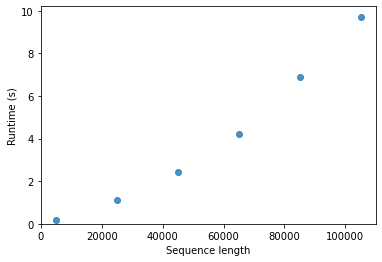

In [58]:
import seaborn as sns
ax = sns.regplot(x="Sequence length", y="Runtime (s)", data=runtimes, fit_reg=False)
ax.set_xlim(0)
ax.set_ylim(0)
ax

This looks to be a [quadratic relationship](http://en.wikipedia.org/wiki/Quadratic_time): the increase in runtime is proportional to the square of sequence length. If you think back to the computation of $F$ and $T$, this makes sense. If our sequences are each five bases long, our matrices will have five rows and five columns, so $5 \times 5 = 25$ cells that need to be filled in by performing some numeric computations. If we double our sequences lengths to ten, our matrices will have ten rows and ten columns, so $10 \times 10 = 100$ cells that need to be filled in. Because each of the numeric computations take roughly the same amount of time (you can take that on faith, or prove it to yourself using ``timeit``), when we double our sequence length we have four times as many cells to compute.

When runtime scales quadratically, that can be a practical limitation for an algorithm. We'd much prefer to see a linear relationship (i.e., if we double our sequence length, our runtime doubles). But this is an inherent issue with pairwise alignment, so it's one that we need to deal with.

One question you might have is whether developing a version of this algorithm which can run in parallel on multiple processors would be an effective way to make it scale to larger data sets. In the next cell, we look and how the plot would change if we could run the alignment process over four processors.

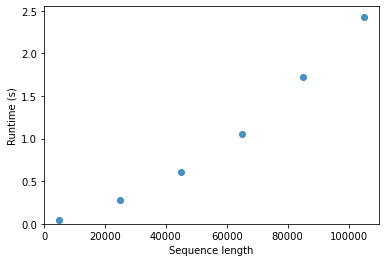

In [59]:
# if we could split this process over more processors (four, for example)
# that would effectively reduce the runtime by 1/4
parallel_runtimes = pd.DataFrame(data=np.asarray([seq_lengths, [t/4 for t in times]]).T, columns=["Sequence length", "Runtime (s)"] )
parallel_runtimes

ax = sns.regplot(x="Sequence length", y="Runtime (s)", data=parallel_runtimes, fit_reg=False)
ax.set_xlim(0)
ax.set_ylim(0)
ax

Notice that the runtimes in the plot are smaller, but shape of the curve is the same. While parallelization can reduce the runtime of an algorithm, it won't change its *computational complexity* (or how its runtime scales as a function of its input size). You can explore the computational complexity of different types of algorithms in the [Big-O Cheat Sheet](http://bigocheatsheet.com/), though it's a fairly advanced introduction to the topic (and one that's usually covered in the second or third year for Computer Science majors).

### Conclusions on the scalability of pairwise sequence alignment with Smith-Waterman 

These are pretty long sequences that we're working with here, and the runtime is still pretty reasonable (only a few seconds for DNA sequences around 100,000 bases), so that suggests this implementation of Smith-Waterman should work ok for aligning pairs of sequences, even if the sequences are fairly long. However, we're often interested in doing more than just pairwise alignment. For example, we may want to align many sequences to each other (which we'll explore in the Multiple Sequence Alignment chapter), or we may want to perform many pairwise alignments (which we'll explore in the Database Searching chapter). In the next chapter we'll begin exploring ways to address this scalability issue by approximating solutions to the problem.

## List of works cited

```{bibliography} ../references.bib
:filter: docname in docnames
```